# Bayesian Probabilistic Matrix Factorization using MCMC

Current status: Does not converge nicely.  
Possible next steps is to compare code to apparent converging version here:  
https://github.com/LoryPack/BPMF/blob/master/Data_analysis.ipynb

In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch
from scipy.stats import wishart
import numpy as np
import matplotlib.pyplot as plt
d = 10

## Load data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


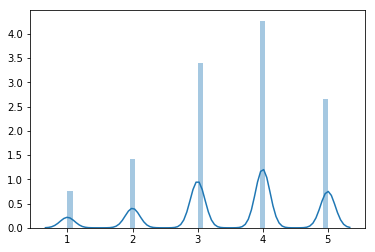

In [2]:
ds = get_movielens_dataset(variant='100K')
#ds.ratings = ds.ratings/5
train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## Explicit Matrix Factorization
Train an explicit model to kickstart the mcmc optimization.
Using spotlight's explicit mf model to do so. The BilinearNet is a modification from the original with no bias.

In [3]:
import torch.nn as nn

from spotlight.layers import ScaledEmbedding, ZeroEmbedding


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 user_embedding_layer=None, item_embedding_layer=None, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        if user_embedding_layer is not None:
            self.user_embeddings = user_embedding_layer
        else:
            self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                                   sparse=sparse)

        if item_embedding_layer is not None:
            self.item_embeddings = item_embedding_layer
        else:
            self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                   sparse=sparse)

        #self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        #self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        #user_bias = self.user_biases(user_ids).squeeze()
        #item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot #+ user_bias + item_bias

## Bayesian MF - one layer
Pretrain model with a standard mf to kickstart mcmc. Then use these weights for further training..

In [4]:
network = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)

model = ExplicitFactorizationModel(n_iter=10, embedding_dim=d, representation=network)
model.fit(train)

rmse = rmse_score(model, test)
print(rmse)

1.0068789


In [5]:
# Initialize vectors
U = model._net.user_embeddings.weight.data
V = model._net.item_embeddings.weight.data
#U = model._net.user_embeddings.weight.data = torch.randn((ds.num_users,d))
#V = model._net.item_embeddings.weight.data = torch.randn((ds.num_items,d))

In [6]:
# M = either U or V.
# K = num_users/num_items (could probably have be inferred by M)

def sample_hyperparam(M, K):
    df0_star = d + K # eq 14
    beta0_star = beta0 + K # eq 14
    M_avg = M.mean(0).view(-1,1)
    mu0_star = (beta0_star*mu0 + K * M_avg) / (beta0_star) # eq 14
    mu0_star = mu0_star.double().view(-1)

    S_avg = (M.unsqueeze(2) * M.unsqueeze(1)).mean(0) # eq 14

    W0_star_inv =  W0_inv + K*S_avg + beta0*K/(beta0_star) * ((mu0-M_avg) * (mu0 - M_avg).transpose(0,1)) # eq 14
    W0_star = W0_star_inv.inverse()

    lambda_M = wishart.rvs(df = df0_star, scale = W0_star)
    lambda_M = torch.tensor(lambda_M).double()
    #print(mu0_star[:2])
    mulvarNormal = torch.distributions.MultivariateNormal(mu0_star, precision_matrix=lambda_M*beta0_star)
    mu_M = mulvarNormal.sample()
    return mu_M.float().view(-1,1), lambda_M.float()

#mu_V, lambda_V = sample_hyperparam(M = V,K = ds.num_items)
#mu_U, lambda_U = sample_hyperparam(M = U,K = ds.num_users)


In [7]:
#P( U_i | R, V, mu_U, lambda_U, alpha) (11)
def get_vector_params(idx, mode, O, mu_K, lambda_K):
    if mode == "user":
        data_idx = ds.user_ids==i
        vec = U[i]
        other_obj = ds.item_ids[data_idx]
    if mode == "item":
        data_idx = ds.item_ids==i
        vec = V[i]
        other_obj = ds.user_ids[data_idx]

    Oj = O[other_obj,]
    r = ds.ratings[data_idx]
    ratings_for_idx = (vec * Oj).sum(1)


    # Calc lambda i star (eq 12)
    lambda_istar =  lambda_K + alpha*(Oj.unsqueeze(2)*Oj.unsqueeze(1)).sum(0)
    covar = lambda_istar.inverse()

    # Calc mu i star (eq 13)
    scoresum = alpha*(Oj*ratings_for_idx.view(-1,1)).sum(0).view(-1,1)
    mu_istar = covar.mm(scoresum + lambda_K.mm(mu_K))
    return mu_istar, lambda_istar

In [8]:
## HYPERPRIORS
beta0 = 10 # Some constant we dont really know
mu0 = 0.1/d # defined in 3.1. think this actually is a vector, but can be treated as scalar due to broadcasting
W0_inv = torch.eye(d) # defined in 3.1
alpha = 1

step: 0 	 rmse train: 0.88, test: 1.01 	 Size user 0.50, item 0.44 	 avg.score: 3.05


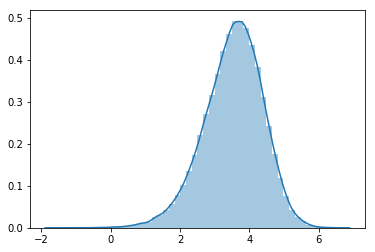

step: 10 	 rmse train: 1.09, test: 1.11 	 Size user 0.40, item 0.39 	 avg.score: 3.15
step: 20 	 rmse train: 1.18, test: 1.20 	 Size user 0.38, item 0.40 	 avg.score: 3.21
step: 30 	 rmse train: 1.27, test: 1.29 	 Size user 0.38, item 0.43 	 avg.score: 3.23
step: 40 	 rmse train: 1.34, test: 1.36 	 Size user 0.37, item 0.44 	 avg.score: 3.12
step: 50 	 rmse train: 1.40, test: 1.43 	 Size user 0.36, item 0.46 	 avg.score: 3.30
step: 60 	 rmse train: 1.47, test: 1.48 	 Size user 0.36, item 0.45 	 avg.score: 3.28
step: 70 	 rmse train: 1.53, test: 1.55 	 Size user 0.36, item 0.47 	 avg.score: 3.34
step: 80 	 rmse train: 1.58, test: 1.60 	 Size user 0.36, item 0.49 	 avg.score: 3.33
step: 90 	 rmse train: 1.64, test: 1.64 	 Size user 0.36, item 0.51 	 avg.score: 3.45
step: 100 	 rmse train: 1.67, test: 1.68 	 Size user 0.37, item 0.51 	 avg.score: 3.17


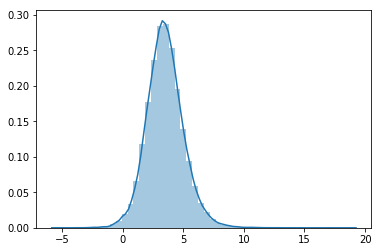

step: 110 	 rmse train: 1.73, test: 1.72 	 Size user 0.37, item 0.51 	 avg.score: 3.22
step: 120 	 rmse train: 1.77, test: 1.77 	 Size user 0.37, item 0.52 	 avg.score: 3.51
step: 130 	 rmse train: 1.81, test: 1.81 	 Size user 0.37, item 0.53 	 avg.score: 3.47
step: 140 	 rmse train: 1.86, test: 1.85 	 Size user 0.38, item 0.52 	 avg.score: 3.46
step: 150 	 rmse train: 1.90, test: 1.90 	 Size user 0.38, item 0.53 	 avg.score: 3.16
step: 160 	 rmse train: 1.94, test: 1.95 	 Size user 0.38, item 0.54 	 avg.score: 3.06
step: 170 	 rmse train: 1.99, test: 1.99 	 Size user 0.38, item 0.55 	 avg.score: 3.53
step: 180 	 rmse train: 2.02, test: 2.03 	 Size user 0.38, item 0.55 	 avg.score: 3.42
step: 190 	 rmse train: 2.04, test: 2.06 	 Size user 0.39, item 0.54 	 avg.score: 3.34
step: 200 	 rmse train: 2.07, test: 2.06 	 Size user 0.38, item 0.56 	 avg.score: 3.53


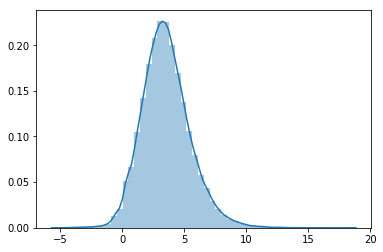

step: 210 	 rmse train: 2.11, test: 2.10 	 Size user 0.39, item 0.57 	 avg.score: 3.51
step: 220 	 rmse train: 2.16, test: 2.15 	 Size user 0.39, item 0.57 	 avg.score: 3.36
step: 230 	 rmse train: 2.17, test: 2.16 	 Size user 0.40, item 0.55 	 avg.score: 3.56
step: 240 	 rmse train: 2.21, test: 2.21 	 Size user 0.40, item 0.55 	 avg.score: 3.33
step: 250 	 rmse train: 2.24, test: 2.25 	 Size user 0.40, item 0.56 	 avg.score: 2.92
step: 260 	 rmse train: 2.26, test: 2.26 	 Size user 0.40, item 0.57 	 avg.score: 3.67
step: 270 	 rmse train: 2.29, test: 2.29 	 Size user 0.40, item 0.57 	 avg.score: 3.53
step: 280 	 rmse train: 2.31, test: 2.32 	 Size user 0.40, item 0.58 	 avg.score: 3.63
step: 290 	 rmse train: 2.33, test: 2.34 	 Size user 0.40, item 0.59 	 avg.score: 3.25
step: 300 	 rmse train: 2.36, test: 2.38 	 Size user 0.41, item 0.59 	 avg.score: 3.43


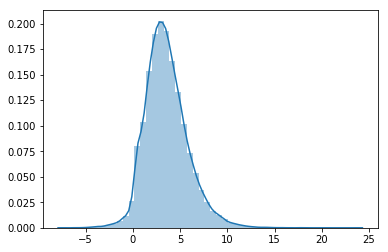

step: 310 	 rmse train: 2.37, test: 2.38 	 Size user 0.41, item 0.58 	 avg.score: 3.39
step: 320 	 rmse train: 2.40, test: 2.41 	 Size user 0.41, item 0.58 	 avg.score: 3.41
step: 330 	 rmse train: 2.42, test: 2.44 	 Size user 0.42, item 0.58 	 avg.score: 3.30
step: 340 	 rmse train: 2.46, test: 2.47 	 Size user 0.42, item 0.59 	 avg.score: 3.71
step: 350 	 rmse train: 2.48, test: 2.49 	 Size user 0.42, item 0.59 	 avg.score: 3.80
step: 360 	 rmse train: 2.49, test: 2.50 	 Size user 0.42, item 0.59 	 avg.score: 3.17
step: 370 	 rmse train: 2.50, test: 2.52 	 Size user 0.42, item 0.58 	 avg.score: 3.57
step: 380 	 rmse train: 2.53, test: 2.55 	 Size user 0.42, item 0.60 	 avg.score: 3.34
step: 390 	 rmse train: 2.55, test: 2.58 	 Size user 0.42, item 0.59 	 avg.score: 3.20
step: 400 	 rmse train: 2.55, test: 2.59 	 Size user 0.42, item 0.59 	 avg.score: 3.39


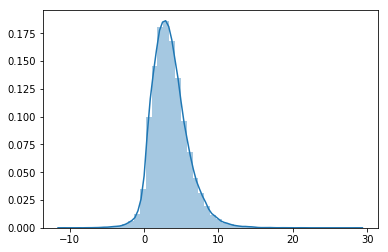

step: 410 	 rmse train: 2.58, test: 2.60 	 Size user 0.42, item 0.59 	 avg.score: 3.46
step: 420 	 rmse train: 2.60, test: 2.62 	 Size user 0.43, item 0.59 	 avg.score: 3.36
step: 430 	 rmse train: 2.60, test: 2.63 	 Size user 0.42, item 0.61 	 avg.score: 3.47
step: 440 	 rmse train: 2.64, test: 2.66 	 Size user 0.43, item 0.61 	 avg.score: 3.31
step: 450 	 rmse train: 2.66, test: 2.68 	 Size user 0.43, item 0.64 	 avg.score: 3.45
step: 460 	 rmse train: 2.68, test: 2.71 	 Size user 0.43, item 0.63 	 avg.score: 3.63
step: 470 	 rmse train: 2.71, test: 2.73 	 Size user 0.44, item 0.63 	 avg.score: 3.45
step: 480 	 rmse train: 2.73, test: 2.75 	 Size user 0.43, item 0.62 	 avg.score: 3.36
step: 490 	 rmse train: 2.74, test: 2.77 	 Size user 0.43, item 0.64 	 avg.score: 3.42
step: 500 	 rmse train: 2.79, test: 2.81 	 Size user 0.44, item 0.65 	 avg.score: 3.81


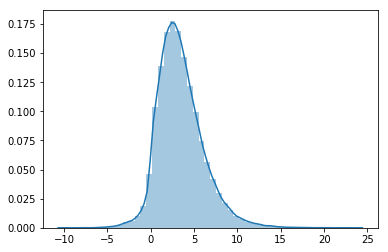

step: 510 	 rmse train: 2.82, test: 2.85 	 Size user 0.44, item 0.65 	 avg.score: 3.61
step: 520 	 rmse train: 2.83, test: 2.86 	 Size user 0.44, item 0.66 	 avg.score: 3.74
step: 530 	 rmse train: 2.86, test: 2.89 	 Size user 0.44, item 0.67 	 avg.score: 3.74
step: 540 	 rmse train: 2.88, test: 2.90 	 Size user 0.44, item 0.66 	 avg.score: 3.55
step: 550 	 rmse train: 2.88, test: 2.90 	 Size user 0.44, item 0.66 	 avg.score: 3.53
step: 560 	 rmse train: 2.91, test: 2.94 	 Size user 0.44, item 0.67 	 avg.score: 3.57
step: 570 	 rmse train: 2.94, test: 2.96 	 Size user 0.44, item 0.66 	 avg.score: 3.69
step: 580 	 rmse train: 2.94, test: 2.96 	 Size user 0.45, item 0.65 	 avg.score: 3.38
step: 590 	 rmse train: 2.93, test: 2.94 	 Size user 0.44, item 0.64 	 avg.score: 3.60
step: 600 	 rmse train: 2.93, test: 2.93 	 Size user 0.45, item 0.63 	 avg.score: 3.25


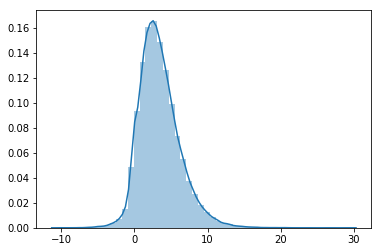

step: 610 	 rmse train: 2.94, test: 2.94 	 Size user 0.45, item 0.63 	 avg.score: 3.42
step: 620 	 rmse train: 2.94, test: 2.94 	 Size user 0.45, item 0.63 	 avg.score: 3.64
step: 630 	 rmse train: 2.94, test: 2.94 	 Size user 0.45, item 0.61 	 avg.score: 3.34
step: 640 	 rmse train: 2.96, test: 2.96 	 Size user 0.45, item 0.60 	 avg.score: 3.34
step: 650 	 rmse train: 2.99, test: 2.99 	 Size user 0.45, item 0.62 	 avg.score: 3.36
step: 660 	 rmse train: 3.01, test: 3.02 	 Size user 0.45, item 0.62 	 avg.score: 3.40
step: 670 	 rmse train: 3.04, test: 3.04 	 Size user 0.45, item 0.64 	 avg.score: 3.65
step: 680 	 rmse train: 3.05, test: 3.06 	 Size user 0.45, item 0.67 	 avg.score: 3.52
step: 690 	 rmse train: 3.09, test: 3.10 	 Size user 0.46, item 0.64 	 avg.score: 3.23
step: 700 	 rmse train: 3.10, test: 3.12 	 Size user 0.46, item 0.63 	 avg.score: 3.40


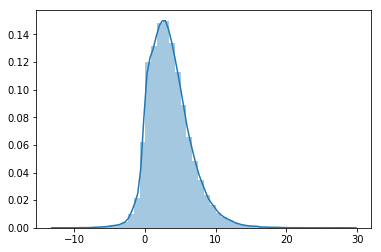

step: 710 	 rmse train: 3.10, test: 3.10 	 Size user 0.46, item 0.64 	 avg.score: 3.58
step: 720 	 rmse train: 3.10, test: 3.11 	 Size user 0.46, item 0.64 	 avg.score: 3.68
step: 730 	 rmse train: 3.12, test: 3.13 	 Size user 0.47, item 0.65 	 avg.score: 3.59
step: 740 	 rmse train: 3.14, test: 3.15 	 Size user 0.47, item 0.65 	 avg.score: 3.48
step: 750 	 rmse train: 3.15, test: 3.16 	 Size user 0.47, item 0.63 	 avg.score: 3.47
step: 760 	 rmse train: 3.16, test: 3.17 	 Size user 0.47, item 0.64 	 avg.score: 3.47
step: 770 	 rmse train: 3.16, test: 3.16 	 Size user 0.47, item 0.64 	 avg.score: 3.61
step: 780 	 rmse train: 3.15, test: 3.16 	 Size user 0.47, item 0.64 	 avg.score: 3.78
step: 790 	 rmse train: 3.17, test: 3.17 	 Size user 0.48, item 0.64 	 avg.score: 3.56
step: 800 	 rmse train: 3.18, test: 3.18 	 Size user 0.48, item 0.66 	 avg.score: 3.54


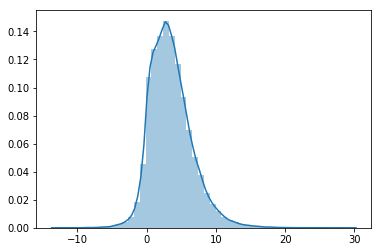

step: 810 	 rmse train: 3.19, test: 3.19 	 Size user 0.47, item 0.66 	 avg.score: 3.62
step: 820 	 rmse train: 3.20, test: 3.19 	 Size user 0.47, item 0.64 	 avg.score: 3.58
step: 830 	 rmse train: 3.22, test: 3.21 	 Size user 0.47, item 0.66 	 avg.score: 3.76
step: 840 	 rmse train: 3.24, test: 3.23 	 Size user 0.47, item 0.66 	 avg.score: 3.54
step: 850 	 rmse train: 3.24, test: 3.22 	 Size user 0.47, item 0.67 	 avg.score: 3.34
step: 860 	 rmse train: 3.23, test: 3.22 	 Size user 0.47, item 0.67 	 avg.score: 3.82
step: 870 	 rmse train: 3.25, test: 3.25 	 Size user 0.47, item 0.68 	 avg.score: 3.48
step: 880 	 rmse train: 3.26, test: 3.27 	 Size user 0.47, item 0.68 	 avg.score: 3.63
step: 890 	 rmse train: 3.26, test: 3.27 	 Size user 0.47, item 0.67 	 avg.score: 3.39
step: 900 	 rmse train: 3.27, test: 3.28 	 Size user 0.47, item 0.68 	 avg.score: 3.26


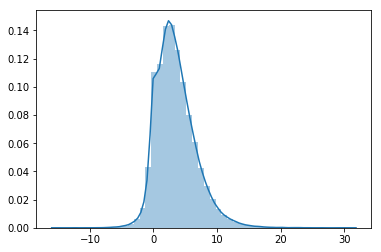

step: 910 	 rmse train: 3.26, test: 3.27 	 Size user 0.47, item 0.67 	 avg.score: 3.96
step: 920 	 rmse train: 3.28, test: 3.29 	 Size user 0.47, item 0.68 	 avg.score: 3.53
step: 930 	 rmse train: 3.29, test: 3.32 	 Size user 0.48, item 0.68 	 avg.score: 3.58
step: 940 	 rmse train: 3.31, test: 3.34 	 Size user 0.48, item 0.67 	 avg.score: 3.36
step: 950 	 rmse train: 3.32, test: 3.35 	 Size user 0.48, item 0.66 	 avg.score: 3.57
step: 960 	 rmse train: 3.33, test: 3.36 	 Size user 0.48, item 0.65 	 avg.score: 3.76
step: 970 	 rmse train: 3.34, test: 3.37 	 Size user 0.49, item 0.64 	 avg.score: 3.33
step: 980 	 rmse train: 3.35, test: 3.37 	 Size user 0.48, item 0.65 	 avg.score: 3.30
step: 990 	 rmse train: 3.36, test: 3.37 	 Size user 0.49, item 0.65 	 avg.score: 3.68


In [9]:
for t in range(1000):
    ### SAMPLE HYPERPARAMETERS ###
    mu_V, lambda_V = sample_hyperparam(M = V,K = ds.num_items)
    mu_U, lambda_U = sample_hyperparam(M = U,K = ds.num_users)

    ### SAMPLE ITEMS ###
    for i in range(1, ds.num_items):
        mu, prec = get_vector_params(i, mode = "item", O=U, mu_K = mu_V, lambda_K=lambda_V)
        mulvarNormal = torch.distributions.MultivariateNormal(mu.view(-1), precision_matrix=prec)
        V[i,] = mulvarNormal.sample()

    ### SAMPLE USERS ###
    for i in range(1, ds.num_users):
        mu, prec = get_vector_params(i, mode = "user", O=V, mu_K = mu_U, lambda_K=lambda_U)
        mulvarNormal = torch.distributions.MultivariateNormal(mu.view(-1), precision_matrix=prec)
        U[i,] = mulvarNormal.sample()
        
    ### JUST LOGGING AFTER THIS: ###
    if t%10 == 0:
        rmse_train = rmse_score(model, train)
        rmse_test = rmse_score(model, test)
        print(f'step: {t} \t rmse train: {rmse_train:.2f}, test: {rmse_test:.2f} \t \
Size user {torch.mean(U**2):.2f}, item {torch.mean(V**2):.2f} \t \
avg.score: {(mu_U*mu_V).sum():.2f}')
    if t%100 == 0:
        seaborn.distplot((U[ds.user_ids,]*V[ds.item_ids,]).sum(1).numpy())
        plt.show()